In [1]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
from scipy import stats

%matplotlib inline

In [2]:
common_corruptions = ['gaussian_noise', 
                      'shot_noise', 
                      'impulse_noise', 
                      'defocus_blur', 
                      'glass_blur', 
                      'motion_blur',
                      'zoom_blur',
                      'snow',
                      'frost',
                      'fog',
                      'brightness',
                      'contrast', 
                      'elastic_transform', 
                      'pixelate', 
                      'jpeg_compression']

corruption_names = [r'Gauss. Noise', 
                    r'Shot Noise', 
                    r'Impulse Noise', 
                    r'Defocus Blur',
                    r'Glass Blur', 
                    r'Motion Blur',
                    r'Zoom Blur', 
                    'Snow', 
                    'Frost', 
                    'Fog', 
                    'Bright.',
                    'Contrast', 
                    r'Elastic Trans.', 
                    r'Pixel.', 
                    r'Jpeg Comp.']

exp_types = ['continual', 'severity_shift', 'in_dist', 'eps_cdf', 'martingale']
# exp_types = ['in_dist', 'eps_cdf']
# exp_types = ['continual', 'severity_shift', 'in_dist']
# model = 'vitbase_timm'
model = 'resnet50_gn_timm'


conversion_labels = {
    'no_adapt': 'No adapt',
    'tent': 'TENT',
    'eata': 'EATA',
    'sar': 'SAR',
    'pem': 'POEM (ours)',
}

palette_methods = ['#ff595e', '#ffca3a', '#8ac926', '#1982c4', '#6a4c93']

In [3]:
# exp_path = Path('./')
exp_path = Path('./exps/')

# exp_type = 'in_dist'
# exp_type = 'natural_shift'
# exp_type = 'bs1'


methods_order = ['no_adapt', 'tent', 'eata', 'sar', 'pem']  # add other methods in desired order



a = []
for p in tqdm(list(exp_path.glob(f'**/*.json'))):
    try:
        with open(p) as f:
            d = json.load(f)
        if d[0]['exp_type'] in exp_types:
            a.extend(d)
    except Exception as e:
        print(p)
    
prog_df = pd.DataFrame(a)


df = pd.DataFrame()
for p in exp_path.glob('**/*.csv'):
    curr_df = pd.read_csv(p)
    df = pd.concat([df, curr_df], ignore_index=True)


prog_df['cdf'] = prog_df['ents'].apply(lambda x: stats.ecdf(np.array(x).flatten()).cdf)
# Convert 'severity_list' from list to comma-separated string
prog_df['severity_list'] = prog_df['severity_list'].apply(lambda x: ','.join(map(str, x)))

# Setting the categorical type with the specified order
prog_df['method'] = pd.Categorical(prog_df['method'], categories=methods_order, ordered=True)
# df['corruption'] = pd.Categorical(df['corruption'], categories=common_corruptions, ordered=True)

# Sorting the DataFrame by 'method'
prog_df = prog_df.sort_values('method')


# Convert the 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d_%H:%M:%S')
df['severity_list'] = df['severity_list'].apply(lambda x: ','.join(map(str, x)) if isinstance(x, list) else x)

# Setting the categorical type with the specified order
df['method'] = pd.Categorical(df['method'], categories=methods_order, ordered=True)
df = df.sort_values('method')



df['sort_key'] = df['method'] == 'pem'
    # Then sort by this key (False values first, then True values)
df = df.sort_values('sort_key')
# df.columns


100%|█████████████████████████████████████████████████| 988/988 [01:55<00:00,  8.54it/s]


In [4]:
# df[df['exp_type'] == 'continual'].groupby(['method', 'model', 'cont_size']).mean()

In [4]:
def process_latex_table(func):
    def wrapper(*args, **kwargs):
        # Call the decorated function to get the LaTeX table
        latex_table = func(*args, **kwargs)

        # Perform the replacements
        replacements = {
            r'resnet50_gn_timm': 'ResNet50 (GN)',
            r'vitbase_timm': 'ViT (LN)',
            r'no adapt': 'No adapt',
            r'no_adapt': 'No adapt',
            r'eata': r'\texttt{EATA}',
            r'tent': r'\texttt{TENT}',
            r'sar': r'\texttt{SAR}',
            r'pem': r'\texttt{POEM (ours)}',
            r'method': 'Method',
            r'model': 'Model',
            r'corruption': 'Corruption'
        }

        for old, new in replacements.items():
            latex_table = latex_table.replace(old, new)

        # Add command to adjust array stretch
        latex_table = r'\renewcommand{\arraystretch}{1.25}{' + latex_table + '}'

        return latex_table

    return wrapper


def prepare_legend_labels(ax, strict: bool = False):
    handles, labels = ax.get_legend_handles_labels()
    print(labels)
    if strict:
        handles = [handle for handle, label in zip(handles, labels) if label.lower() in conversion_labels]
        labels = [conversion_labels[label.lower()] for label in labels if label.lower() in conversion_labels]
    
    
    labels = [conversion_labels[label.lower()] if label.lower() in conversion_labels else label for label in labels]
    print(labels)
    return handles, labels
    

In [5]:

def plot_in_dist(df, ax):
    df = df[(df['exp_type'] == 'in_dist')]

    models = df['model'].unique()
    assert len(models) == 1, "Only one model df at a time!"
    
    
    df = df.groupby('method')[['ece', 'model_delta', 'top1']].mean().reset_index()
    ax = sns.scatterplot(data=df, x='ece', y='model_delta', hue='method', style='method',
                 markers='*', s=200, edgecolor='black', linewidth=1., ax=ax, alpha=0.75)  # s controls size of markers

    # Creating custom labels for the legend
    # Extract unique methods and their average top1 accuracies

    ax.legend_.remove()
    
    ax.set_xlabel("ECE", fontsize=12)
    # axs[i].set_ylabel(r"Model Delta $\|\theta - \hat{\theta}\|_2^2$", fontsize=12)
    ax.set_ylabel(r"$\|\omega\|_F^2$", fontsize=12)
    
    # Get current axis limits
    x_limits = ax.get_xlim()
    y_limits = ax.get_ylim()
    
    # Define padding as a fraction of the range of the axis limits
    x_padding = (x_limits[1] - x_limits[0]) * 0.05  # 5% padding
    y_padding = (y_limits[1] - y_limits[0]) * 0.05  # 5% padding
    
    # Set new axis limits with padding
    ax.set_xlim(x_limits[0] - x_padding, x_limits[1] + x_padding)
    ax.set_ylim(y_limits[0] - y_padding, y_limits[1] + y_padding)

    return ax




@process_latex_table
def in_dist_result_table(df):
    # Group data by model and method and calculate mean and SEM for specified metrics
    stats = df[df['exp_type'] == 'in_dist'].groupby(['model', 'method']).agg(
        mean_top1=('top1', 'mean'),
        sem_top1=('top1', 'sem'),
        mean_top5=('top5', 'mean'),
        sem_top5=('top5', 'sem'),
        mean_ece=('ece', 'mean'),
        sem_ece=('ece', 'sem'),
        mean_model_delta=('model_delta', 'mean'),
        sem_model_delta=('model_delta', 'sem')
    )

    # Apply a function to format the results with SEM where applicable
    def format_result(row, metric):
        mean = row[f'mean_{metric}']
        sem = row[f'sem_{metric}']
        if 'ece' in metric:
            if row.name[1] != 'no adapt':  # row.name[1] should correspond to the 'method' level
                return f"${mean:.4f}_" + "{" + f"\pm {sem:.2f}" + "}$"
            else:
                return f"${mean:.4f}$"
        else:
            if row.name[1] != 'no adapt':  # row.name[1] should correspond to the 'method' level
                return f"${mean:.2f}_" + "{" + f"\pm {sem:.2f}" + "}$"
            else:
                return f"${mean:.2f}$"

    # Applying the formatting function to each metric
    for metric in ['top1', 'top5', 'ece', 'model_delta']:
        stats[f'result_{metric}'] = stats.apply(format_result, axis=1, metric=metric)

    # Selecting formatted results and generating the LaTeX table
    results = stats[[f'result_{m}' for m in ['top1', 'top5', 'ece', 'model_delta']]]
    latex_table = results.to_latex(
        escape=False,
        index=True,
        multirow=True,
        multicolumn=True,
        multicolumn_format='c',
        column_format='llcccc',  # Adjust based on the number of metrics (4 in this case) + 'll' for the two levels of index
        caption='In-Distribution Performance by Model and Method',
        label='tab:indist_performance',
        position='ht'
    )
    return latex_table


@process_latex_table
def bs1_results_summary(df):
      
    # Filter data for experiment type 'bs1'
    df = df[(df['exp_type'] == 'bs1')]

    # Assume 'common_corruptions' and 'corruption_names' are provided
    rename_dict = dict(zip(common_corruptions, corruption_names))
    
    # Categorize and order corruptions for consistent processing
    df['corruption'] = pd.Categorical(df['corruption'], categories=common_corruptions, ordered=True)
    df = df.sort_values(['model', 'method', 'corruption'])
    
    # Humanize method names by replacing underscores with spaces
    df['method'] = df['method'].apply(lambda x: x.replace('_', ' '))

    # Group data by model and method, calculate mean and SEM over all corruptions
    grouped_df = df.groupby(['model', 'method'])['top1'].agg(['mean', 'sem']).reset_index()
    grouped_df['sem'] = grouped_df['sem'].fillna(0)  # Fill missing standard errors with zero

    # Format results with mean ± SEM
    # grouped_df['result'] = grouped_df.apply(
    #     lambda row: f"${row['mean']:.2f}" + "_{" + f"\pm {row['sem']:.2f}" + "}$",
    #     axis=1
    # )

    grouped_df['result'] = grouped_df.apply(
        lambda row: f"${row['mean']:.2f}$",
        axis=1
    )

    pivot_df = grouped_df.pivot(index='method', columns='model', values='result')

    # Optionally: Rename columns if specific names are provided for models in 'rename_dict'
    pivot_df.rename(columns=rename_dict, inplace=True)

    # Generate LaTeX code for the table with appropriate formatting
    latex_table = pivot_df.to_latex(
        escape=False,
        index=True,
        caption='Mean Top-1 Accuracy by Method and Model across All Corruptions (with Standard Error)',
        label='tab:mean_accuracy_se',
        position='ht',
        float_format="{:0.2f}".format
    )

    # Generate LaTeX code for the table with appropriate formatting
    latex_table = pivot_df.to_latex(
        escape=False,
        index=True,
        caption='Mean Top-1 Accuracy by Method and Model across All Corruptions',
        label='tab:mean_accuracy',
        position='ht',
        float_format="{:0.2f}".format
    )

    return latex_table


@process_latex_table
def bs1_results(df):
    df = df[(df['exp_type'] == 'bs1')]

    rename_dict = dict(zip(common_corruptions, corruption_names))
    
    df['corruption'] = pd.Categorical(df['corruption'], categories=common_corruptions, ordered=True)
    df = df.sort_values(['model', 'method', 'corruption'])  # Assuming 'model' is a column
    df['method'] = df['method'].apply(lambda x: x.replace('_', ' '))

    # Group data by model, method, and corruption
    grouped_df = df.groupby(['model', 'method', 'corruption'])['top1'].agg(['mean', 'sem']).reset_index()
    grouped_df['sem'] = grouped_df['sem'].fillna(0)
    grouped_df['result'] = grouped_df.apply(lambda row: f"${row['mean']:.2f}_" + "{"  + f"\pm {row['sem']:.1f}" + "}$"   if row['method'] != 'no adapt' else f"${row['mean']:.2f}$", axis=1)

    # Create a pivot table with models and methods as multi-level index
    pivot_df = grouped_df.pivot_table(index=['model', 'method'], columns='corruption', values='result', aggfunc='first')
    pivot_df.rename(columns=rename_dict, inplace=True)

    # Convert the pivot table to LaTeX
    # Generate LaTeX code for the table
    latex_table = pivot_df.to_latex(
        escape=False,
        index=True,
        multirow=True,
        multicolumn=True,
        multicolumn_format='c',
        column_format='ll' + 'c' * len(common_corruptions),  # Adjust based on the number of corruption types + 'll' for the two levels of index
        caption='Top-1 Accuracy by Method and Corruption',
        label='tab:accuracy_se',
        position='ht'
    )

    # Optionally adjust LaTeX table formatting if necessary
    latex_table = latex_table.replace(r'\begin{tabular}', r'\resizebox{\linewidth}{!}{\begin{tabular}')
    latex_table = latex_table.replace(r'\end{tabular}', r'\end{tabular}}')

    return latex_table

def plot_bs1(df, ax):
    df = df[df['exp_type'] == 'bs1']
    models = df['model'].unique()
    assert len(models) == 1, "Only one model df at a time!"
    
    if models[0] == 'vitbase_timm':
        title = 'ViT (LN) Acc.'
    else:
        title = 'ResNet50 (GN) Acc.'    

    # Create a mapping dictionary from common_corruptions to corruption_names
    rename_dict = dict(zip(common_corruptions, corruption_names))

    # Ensure the data is sorted by the common_corruptions order
    df['corruption'] = pd.Categorical(df['corruption'], categories=common_corruptions, ordered=True)
    df.sort_values('corruption', inplace=True)

    # Rename the corruption categories
    df['corruption'] = df['corruption'].map(rename_dict)

    # Create the bar plot
    ax = sns.barplot(x='corruption', y='top1', hue='method', data=df, ax=ax, errorbar="ci")
    ax.set_ylabel(title, labelpad=20, fontsize=12)

    # Rotate x-axis labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.legend_.remove()
    return ax

def plot_severity_shift(prog_df, ax):
    prog_df = prog_df[(prog_df['exp_type'] == 'severity_shift')]

    models = prog_df['model'].unique()

    assert len(models) == 1, "Only one model df at a time!"
    severity_list = prog_df['severity_list'].unique()

    assert len(severity_list) == 1, "Only one severity list"
    
    if severity_list[0] == '1,2,3,4,5,4,3,2,1':
        ax.set_title(r'Low $\to$ High $\to$ Low') 
    else:
        ax.set_title(r'High $\to$ Low $\to$ High')

    if models[0] == 'vitbase_timm':
        title = 'ViT(LN) Acc.'
    else:
        title = 'ResNet(GN) Acc.'
    
    # Row Titles
    ax.set_ylabel(title, labelpad=20, fontsize=12)
    

    cont_size, model, severity_list = 1000, models[0], severity_list[0]
    severity_list = severity_list.split(',')
    ticks_positions = [(i) for i in range(len(severity_list))]
    
    window_size = cont_size // 1

    prog_df['accs1_per_corr'] = prog_df['accs1'].apply(lambda x: np.array(x).reshape(-1, window_size).mean(axis=1))
    rows = []
    for _, row in prog_df.iterrows():
        for idx, val in enumerate(row['accs1_per_corr']):
            rows.append({**row.to_dict(), 'accs1_per_corr_value': val, 'time_point': idx})
    expanded_df = pd.DataFrame(rows)
            
    for j in range(len(severity_list)):
        ax.axvline(j, color='k', linestyle='--',alpha=0.30)
        
    sns.lineplot(data=expanded_df, x='time_point', y='accs1_per_corr_value', hue='method', style='exp_type', markers=True, dashes=False, ax=ax, errorbar=('ci', 0.68))    
    for line in ax.get_lines():
        # Get the data for each line
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        
        # Get the marker style
        marker = line.get_marker()
        
        # Plot each marker with an edge color
        ax.plot(x_data, y_data, linestyle='None', marker=marker, markeredgecolor='#343434', markerfacecolor=line.get_color(), markersize=5, alpha=0.80)

    # Get current axis limits
    y_limits = (expanded_df['accs1_per_corr_value'].min(), expanded_df['accs1_per_corr_value'].max())
        
    # Set new axis limits with padding
    ax.set_ylim(y_limits[0], y_limits[1])
        
    ax.legend_.remove()

    ax.set_xticks(ticks_positions, severity_list, fontsize=11)
    # Draw an arrow using annotate
    ax.annotate(
        r'time', 
        xy=(0.1, -0.45), xycoords='axes fraction',  # Start of the arrow
        xytext=(0.9, -0.45), textcoords='axes fraction',  # End of the arrow
        ha='center', va='center', fontsize=12,
        arrowprops=dict(arrowstyle="<|-", lw=1.2, color='k'),  # Style of the arrow
        annotation_clip=False  # Allows drawing outside the plot area
    )

    xlabel = ax.set_xlabel(f'Severity Level (Gaussian Noise)', fontsize=12)
    return ax

def plot_corruption_shift_seg_size(df, ax):
    df = df[(df['exp_type'] == 'continual')]

    models = df['model'].unique()
    assert len(models) == 1, "Only one model df at a time!"

    df = df[df['cont_size'] <= 2000]
    gb = df.groupby(['model', 'level'])

    if models[0] == 'vitbase_timm':
        title = 'ViT(LN) Acc.'
    else:
        title = 'ResNet(GN) Acc.'
    
    # Row Titles
    ax.set_ylabel(title, labelpad=20, fontsize=12)
        
    ax = sns.lineplot(df, x='cont_size', y='top1', hue='method', markers=True, style='exp_type', ax=ax, errorbar=('ci', 0.68))
    for line in ax.get_lines():
        # Get the data for each line
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        
        # Get the marker style
        marker = line.get_marker()
        
        # Plot each marker with an edge color
        ax.plot(x_data, y_data, linestyle='None', marker=marker, markeredgecolor='#343434', markerfacecolor=line.get_color(), markersize=5, alpha=0.80)
    ax.legend_.remove()
    ax.set_xlabel("Corruption Segment Size", fontsize=12)
    
    # Set the positions and labels for x-axis ticks
    tick_positions = [100, 500, 1000, 2000]  # These should match the actual data points if they are present
    ax.set_xticks(tick_positions)  # Setting the tick positions
    ax.set_xticklabels(tick_positions, fontsize=11)  # Setting the tick labels

    
    # Define a function to format the y-axis ticks as integers if they are whole numbers
    def format_func(value, tick_number):
        # if value.is_integer():
        #     return f"{int(value)}"
        # else:
        return f"{value:.1f}"

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))

    return ax
    
    


def plot_corruption_shift_corrpution_acc(prog_df, ax):
    
    prog_df = prog_df[(prog_df['exp_type'] == 'continual')]
    ticks_positions = [(i) for i in range(len(common_corruptions))]

    models = prog_df['model'].unique()
    assert len(models) == 1, "Only one model df at a time!"

    
    cont_size = 1000
    prog_df = prog_df[prog_df['cont_size'] == cont_size]
    window_size = cont_size 

    # fig, ax = plt.subplots(1, 1, figsize=(10, 4), sharex='col')
    # fig.subplots_adjust(hspace=0.07, wspace=0.05)  # hspace controls the height (space between rows), wspace controls the width (space between columns)

    if models[0] == 'vitbase_timm':
        title = 'ViT(LN) Acc.'
    else:
        title = 'ResNet(GN) Acc.'

    # Row Titles
    ax.set_ylabel(title, labelpad=20, fontsize=12)



    prog_df['accs1_per_corr'] = prog_df['accs1'].apply(lambda x: np.array(x).reshape(-1, window_size).mean(axis=1))
    rows = []
    for _, row in prog_df.iterrows():
        for idx, val in enumerate(row['accs1_per_corr']):
            rows.append({**row.to_dict(), 'accs1_per_corr_value': val, 'time_point': idx})
    expanded_df = pd.DataFrame(rows)
        
    # Now plot with seaborn
    for j in range(len(common_corruptions)):
        ax.axvline(j, color='k', linestyle='--',alpha=0.25)

    sns.lineplot(data=expanded_df, x='time_point', y='accs1_per_corr_value', hue='method', style='exp_type', ax=ax, markers=True, dashes=False, errorbar=('ci', 0.68), alpha=0.85)
    # Get current axis limits
    
    # Extract the y-data from all lines to find the actual min and max values
    all_y_data = []
    for line in ax.get_lines():
        y_data = line.get_ydata()
        if len(y_data) > 3:
            all_y_data.extend(y_data)
    
    # Set y-axis limits based on actual min and max values of the markers
    y_limits = (min(all_y_data), max(all_y_data))
    print(y_limits)
    ax.set_ylim(y_limits[0]*0.80, y_limits[1]*1.05)
        
    for line in ax.get_lines():
        # Get the data for each line
        x_data = line.get_xdata()
        y_data = line.get_ydata()
        
        # Get the marker style
        marker = line.get_marker()
        
        # Plot each marker with an edge color
        ax.plot(x_data, y_data, linestyle='None', marker=marker, markeredgecolor='#343434', markerfacecolor=line.get_color(), markersize=5, alpha=0.80)

    
    ax.legend_.remove()
    # handles, labels = ax.get_legend_handles_labels()
    
    # if i == 0:
    #     new_list = [(' '.join(label.split('_')).capitalize(), handle) for label, handle in zip(labels, handles) if label in df['method'].unique() ]
    #     handles = [a[1] for a in new_list]
    #     labels = [a[0] for a in new_list]
    #     axs[i].legend(handles, labels, title='Method', loc='best', bbox_to_anchor=(1.03, 1), borderaxespad=0.)

    ax.annotate(
        r'time', 
        xy=(0.1, -0.62), xycoords='axes fraction',  # Start of the arrow
        xytext=(0.9, -0.62), textcoords='axes fraction',  # End of the arrow
        ha='center', va='center', fontsize=12,
        arrowprops=dict(arrowstyle="<|-", lw=1.2, color='k'),  # Style of the arrow
        annotation_clip=False  # Allows drawing outside the plot area
    )
    # plt.title("")
    ax.set_xticks(ticks_positions, corruption_names, rotation=45, ha="center")
    # # Add an arrow across the x-axis

    ax.set_xlim(-0.5, 17)

    sev = expanded_df['level'].unique()[0]
    ax.set_xlabel(f'Corruption Type (Severity {sev})', fontsize=12)


    
    return ax    



def plot_epsilons(prog_df, ax):

    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    
    # Filter the DataFrame for 'severity_shift'
    shift_df = prog_df[(prog_df['method'] == 'pem') & (prog_df['exp_type'] == 'eps_cdf') & (prog_df['corruption'] == 'brightness')]
    shift_df = shift_df.explode('epsilons')
    shift_df.reset_index(inplace=True)
    shift_df['idx'] = shift_df.groupby('index').cumcount()
    shift_df = shift_df[shift_df['idx'] % 50 == 0]  # Thinning the data
    shift_df.rename(columns={'index': 'original_index', 'epsilons': 'epsilon_shift'}, inplace=True)
    shift_df['epsilon_shift'] = shift_df['epsilon_shift'].astype(float)
    
    
    # Filter the DataFrame for 'in_dist'
    dist_df = prog_df[(prog_df['method'] == 'pem') & (prog_df['exp_type'] == 'in_dist')]
    dist_df = dist_df.explode('epsilons')
    dist_df.reset_index(inplace=True)
    dist_df['idx'] = dist_df.groupby('index').cumcount()
    dist_df = dist_df[dist_df['idx'] % 250 == 0]  # Thinning the data similarly
    dist_df.rename(columns={'index': 'original_index', 'epsilons': 'epsilon_dist'}, inplace=True)
    dist_df['epsilon_dist'] = dist_df['epsilon_dist'].astype(float)
    

    # sns.lineplot(data=dist_df, x='idx', y='epsilon_dist', label='In Distribution', color='#3BB273', ax=ax, errorbar=('ci', 0.68), linewidth=2)
    sns.lineplot(data=dist_df, x='idx', y='epsilon_dist', label='In Distribution', color='#6AC8AC', ax=ax, errorbar=('ci', 0.68), linewidth=2)
    
    # Plot severity_shift line with selective markers
    # sns.lineplot(data=shift_df, x='idx', y='epsilon_shift', hue='level', dashes=False, palette=['#D6B11F', '#E15554'], ax=ax, linewidth=2)
    sns.lineplot(data=shift_df, x='idx', y='epsilon_shift', hue='level', dashes=False, palette=['#FAA689', '#F54D3B'], ax=ax, linewidth=2)
    # ax = sns.lineplot(data=shift_df, x='idx', y='epsilon_shift', hue='severity_list', palette='Set1', ax=ax)
    ax.set_xlabel(r'Example $j$', fontsize=12)
    ax.set_ylabel(r'$\epsilon$', fontsize=14)
        
    eps_max = shift_df['epsilon_shift'].max()
    eps_min = shift_df['epsilon_shift'].min()
    ax.set_ylim(eps_min-0.15, eps_max + 0.15)
    ax.set_xlim(-250, 37500)
    # ax.set_xticks([1000 * i for i in range(10)])

    return ax


In [64]:
print(bs1_results(df))

\renewcommand{\arraystretch}{1.25}{\begin{table}[ht]
\centering
\caption{Top-1 Accuracy by Method and Corruption}
\label{tab:accuracy_se}
\resizebox{\linewidth}{!}{\begin{tabular}{llccccccccccccccc}
\toprule
             & Corruption &       Gauss. Noise &         Shot Noise &      Impulse Noise &       Defocus Blur &         Glass Blur &        Motion Blur &          Zoom Blur &               Snow &              Frost &                Fog &            Bright. &           Contrast &     Elastic Trans. &             Pixel. &         Jpeg Comp. \\
Model & Method &                    &                    &                    &                    &                    &                    &                    &                    &                    &                    &                    &                    &                    &                    &                    \\
\midrule
\multirow{5}{*}{ResNet50 (GN)} & No adapt &            $22.11$ &            $23.05$ &            $22.04$ &

/tmp/ipykernel_498056/2427465974.py:152: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['corruption'] = pd.Categorical(df['corruption'], categories=common_corruptions, ordered=True)


In [33]:
# fig = plt.figure(figsize=(10, 5))  # Adjust figure size as needed
# gs = fig.add_gridspec(2, 10, height_ratios=[1, 1])  # Adjusted wspace for general spacing

# # Create subplots using gridspec (adjust indices to incorporate spacing column)
# ax1 = fig.add_subplot(gs[0, :])
# ax2 = fig.add_subplot(gs[1, :])


# plot_bs1(df[(df['model'] == 'vitbase_timm')], ax1)
# plot_bs1(df[(df['model'] == 'resnet50_gn_timm')], ax2)
# handles, labels = prepare_legend_labels(ax1, True)
# ax1.legend(handles, labels, title='Method', loc='best', bbox_to_anchor=(1.03, 1), borderaxespad=0.)

# ax1.set_xlabel("")
# ax1.set_xticks([])

# plt.show()

In [ ]:

# Assuming you have functions `plot_func1`, `plot_func2`, and `plot_func3` for plotting
# and your list of axes (`axes`) (optional for preserving styles)

# Create a new figure and a custom grid with 2 columns
fig = plt.figure(figsize=(10, 5), constrained_layout=True)
gs = fig.add_gridspec(2, 18, height_ratios=[1, 1], hspace=0.1, wspace=0.0)  # Adjusted wspace for general spacing

# Create subplots using gridspec (adjust indices to incorporate spacing column)
ax1 = fig.add_subplot(gs[1, 0:6])  # Top left subplot, spans 2 columns
ax2 = fig.add_subplot(gs[1, 6:12])  # Next two columns
ax3 = fig.add_subplot(gs[1, 12:])  # Skip one column for extra space, then next two columns
ax4 = fig.add_subplot(gs[0, :18])    # Bottom subplot spanning entire width

plot_severity_shift(prog_df[(prog_df['model'] == model) & (prog_df['severity_list'] == '1,2,3,4,5,4,3,2,1')], ax1)
plot_severity_shift(prog_df[(prog_df['model'] == model) & (prog_df['severity_list'] == '5,4,3,2,1,2,3,4,5')], ax2)
plot_corruption_shift_seg_size(df[df['model'] == model], ax3)
plot_corruption_shift_corrpution_acc(prog_df[prog_df['model'] == model], ax4)

ax2.set_ylabel("")
ax3.set_ylabel("")
ax2.set_yticks([])

ax1.set_title('')
ax2.set_title('')
ax3.set_title('')
ax4.set_title('')


handles, labels = prepare_legend_labels(ax4, True)
print(labels)
# Filter handles and labels based on whether the label is in conversion_labels
ax4.legend(handles, labels, title='Method', loc='best', borderaxespad=0.2)

# fig, ax = plt.subplots(constrained_layout=True)
plt.savefig(f'figures/{model}_cont.svg', format='svg')
plt.show()

/tmp/ipykernel_1307040/3501607127.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prog_df['accs1_per_corr'] = prog_df['accs1'].apply(lambda x: np.array(x).reshape(-1, window_size).mean(axis=1))


(11.63, 69.39999999999999)
['method', 'no_adapt', 'tent', 'eata', 'sar', 'pem', 'exp_type', 'continual']
['No adapt', 'TENT', 'EATA', 'SAR', 'POEM (ours)']
['No adapt', 'TENT', 'EATA', 'SAR', 'POEM (ours)']


Index(['top1', 'top5', 'accs1', 'accs5', 'ents', 'ece', 'model_delta', 'data',
       'data_corruption', 'v2_path', 'output', 'seed', 'gpu', 'debug',
       'workers', 'test_batch_size', 'if_shuffle', 'level', 'corruption',
       'fisher_size', 'fisher_alpha', 'e_margin', 'd_margin', 'method',
       'model', 'exp_type', 'cont_size', 'severity_list', 'temp',
       'exp_comment', 'sar_margin_e0', 'imbalance_ratio', 'gamma', 'eps_clip',
       'loss_fn', 'ub4', 'u_thresh', 'lr_factor', 'device', 'timestamp',
       'exp_name', 'lr', 'print_freq', 'epsilons', 'u_before', 'u_after',
       'martingales', 'cdf'],
      dtype='object')

/tmp/ipykernel_1307040/1099013439.py:9: UserWarning: 
The markers list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterplot(data=df, x='ece', y='model_delta', hue='method', style='method',


['no_adapt', 'tent', 'eata', 'sar', 'pem']
['No adapt', 'TENT', 'EATA', 'SAR', 'POEM (ours)']


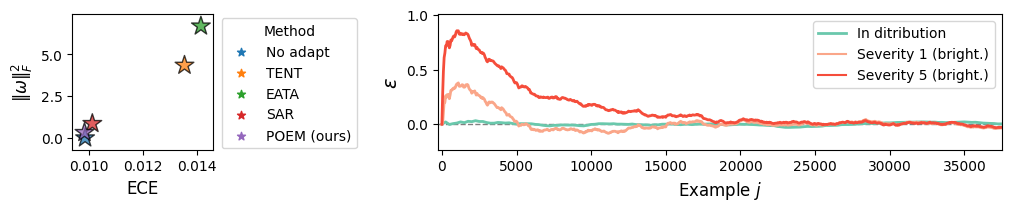

In [48]:
fig = plt.figure(figsize=(10, 2), constrained_layout=True)  # Adjust figure size as needed
gs = fig.add_gridspec(2, 10, height_ratios=[1, 1], wspace=0.25)  # Adjusted wspace for general spacing

# Create subplots using gridspec (adjust indices to incorporate spacing column)
ax1 = fig.add_subplot(gs[:, :2])  # Top left subplot, spans 2 columns
ax2 = fig.add_subplot(gs[:, 2:])  # Top left subplot, spans 2 columns


ax1 = plot_in_dist(df[df['model'] == model], ax1)
# ax2 = plot_epsilons(prog_df[(prog_df['model'] == model) & (prog_df['severity_list'] == '5,4,3,2,1,2,3,4,5')], ax2)
filtered_df = prog_df[(prog_df['model'] == model)]
plot_epsilons(filtered_df, ax2)
handles, labels = prepare_legend_labels(ax1)
ax1.legend(handles, labels, title='Method', loc='best', bbox_to_anchor=(1.03, 1), borderaxespad=0.3)

# Adjusting legend to include both lines
handles, labels = ax2.get_legend_handles_labels()
# new_list = [(r'$\to$'.join(label.split(',')).capitalize(), handle) for label, handle in zip(labels, handles)]

new_labels = []

for label in labels:
    if 'in' not in label.lower():
        new_labels.append(f'Severity {label} (bright.)')
    else:
        new_labels.append(r'In ditribution')


# handles = [a[1] for a in new_list]
# labels = [a[0] for a in new_list]
ax2.legend(handles, new_labels, loc='best', fontsize=10)

ax1.set_title('')
ax2.set_title('')

plt.savefig(f'figures/{model}_in_dist_with_eps.svg', format='svg')
# plot_in_dist(df[df['model'] == 'vitbase_timm'], ax1)

In [27]:
print(in_dist_result_table(df))


\renewcommand{\arraystretch}{1.25}{\begin{table}[ht]
\centering
\caption{In-Distribution Performance by Model and Method}
\label{tab:indist_performance}
\begin{tabular}{llcccc}
\toprule
             &     &         result_top1 &         result_top5 &           result_ece &  result_Model_delta \\
Model & Method &                     &                     &                      &                     \\
\midrule
\multirow{5}{*}{ResNet50 (GN)} & No adapt &  $79.95_{\pm 0.04}$ &  $94.94_{\pm 0.02}$ &  $0.0243_{\pm 0.00}$ &   $0.00_{\pm 0.00}$ \\
             & Tent &  $79.63_{\pm 0.05}$ &  $94.78_{\pm 0.02}$ &  $0.0894_{\pm 0.00}$ &   $5.90_{\pm 0.01}$ \\
             & EATA &  $79.91_{\pm 0.04}$ &  $94.89_{\pm 0.02}$ &  $0.0709_{\pm 0.00}$ &  $10.53_{\pm 0.05}$ \\
             & SAR &  $79.97_{\pm 0.05}$ &  $94.93_{\pm 0.02}$ &  $0.0250_{\pm 0.00}$ &   $8.14_{\pm 0.01}$ \\
             & PEM (ours) &  $79.95_{\pm 0.04}$ &  $94.93_{\pm 0.02}$ &  $0.0243_{\pm 0.00}$ &   $0.17_{\pm 0.03}$ \\


/home/yarinbar/.miniconda3/envs/tent/lib/python3.10/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


5


/tmp/ipykernel_612557/1760432053.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=no_adapt_data, x='Quantile', y='Probability', label=r'$\hat{F}_s$', color='#181818', linestyle=':', linewidth=2.5, zorder=3, ax=ax, palette=palette_methods)
/tmp/ipykernel_612557/1760432053.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=no_adapt_data, x='Quantile', y='Probability', label=r'$\hat{F}_s$', color='#181818', linestyle=':', linewidth=2.5, zorder=3, ax=ax, palette=palette_methods)


NameError: name 'prepare_legend_labels' is not defined

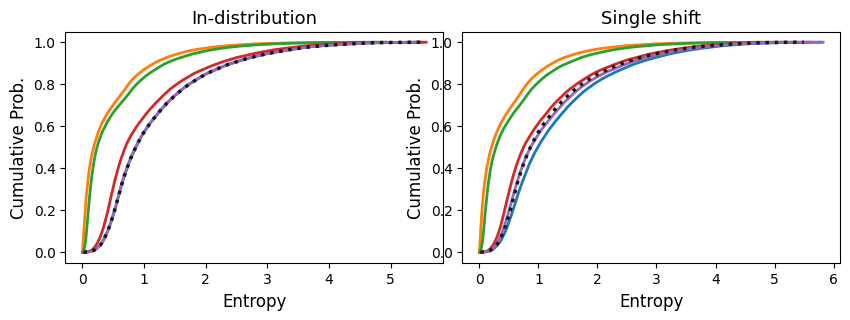

In [34]:

def plot_cdfs(expanded_df, ax, title):
    methods = expanded_df['method'].unique()
    for i, method in enumerate(methods):
        if method == 'target':
            continue
            
        subset = expanded_df[expanded_df['method'] == method]
        sns.lineplot(data=subset, x='Quantile', y='Probability', label=method, linestyle='-', ax=ax, linewidth=2)
    # Customize no_adapt method if exists in this subset
    if 'target' in methods:
        no_adapt_data = expanded_df[expanded_df['method'] == 'target']
        sns.lineplot(data=no_adapt_data, x='Quantile', y='Probability', label=r'$\hat{F}_s$', color='#181818', linestyle=':', linewidth=2.5, zorder=3, ax=ax, palette=palette_methods)
    ax.set_title(title, fontsize=13)
    ax.set_xlabel(r'Entropy', fontsize=12)
    ax.set_ylabel(r'Cumulative Prob.', fontsize=12)
    ax.legend_.remove()
    # ax.legend(title='Method')



prog_df_in_dist = prog_df.loc[(prog_df['exp_type'] == 'in_dist') & (prog_df['method'] == 'no_adapt') & (prog_df['model'] == model) &  (prog_df['seed'] == 2024)]

# Safely modify columns using .loc
prog_df_in_dist.loc[:, 'cdf_p'] = prog_df_in_dist['cdf'].apply(lambda x: x.probabilities)
prog_df_in_dist.loc[:, 'cdf_q'] = prog_df_in_dist['cdf'].apply(lambda x: x.quantiles)

# Repeat for another filtered DataFrame
prog_df_filtered = prog_df.loc[(prog_df['exp_type'] == 'in_dist') & (prog_df['model'] == model) &  (prog_df['seed'] == 2024)]

# Safely modify columns using .loc
prog_df_filtered.loc[:, 'cdf_p'] = prog_df_filtered['cdf'].apply(lambda x: x.probabilities)
prog_df_filtered.loc[:, 'cdf_q'] = prog_df_filtered['cdf'].apply(lambda x: x.quantiles)

# Expand the DataFrame
rows = []
for _, row in prog_df_filtered.iterrows():
    method = row['method']
    for p, q in zip(row['cdf_p'], row['cdf_q']):
        rows.append({'method': method, 'Probability': p, 'Quantile': q})

for _, row in prog_df_in_dist.iterrows():
    method = 'target'
    for p, q in zip(row['cdf_p'], row['cdf_q']):
        rows.append({'method': method, 'Probability': p, 'Quantile': q})

expanded_df_1 = pd.DataFrame(rows)



prog_df_in_dist = prog_df.loc[(prog_df['exp_type'] == 'in_dist') & (prog_df['method'] == 'no_adapt') & (prog_df['model'] == model) &  (prog_df['seed'] == 2024)]

# Safely modify columns using .loc
prog_df_in_dist.loc[:, 'cdf_p'] = prog_df_in_dist['cdf'].apply(lambda x: x.probabilities)
prog_df_in_dist.loc[:, 'cdf_q'] = prog_df_in_dist['cdf'].apply(lambda x: x.quantiles)

# Repeat for another filtered DataFrame
prog_df_filtered = prog_df.loc[(prog_df['exp_type'] == 'eps_cdf') & (prog_df['corruption'] == 'brightness') & (prog_df['level'] == 1) & (prog_df['model'] == model) &  (prog_df['seed'] == 2024)]
print(len(prog_df_filtered))

# Safely modify columns using .loc
prog_df_filtered.loc[:, 'cdf_p'] = prog_df_filtered['cdf'].apply(lambda x: x.probabilities)
prog_df_filtered.loc[:, 'cdf_q'] = prog_df_filtered['cdf'].apply(lambda x: x.quantiles)


# Expand the DataFrame
rows = []
for _, row in prog_df_filtered.iterrows():
    method = row['method']
    for p, q in zip(row['cdf_p'], row['cdf_q']):
        rows.append({'method': method, 'Probability': p, 'Quantile': q})

for _, row in prog_df_in_dist.iterrows():
    method = 'target'
    for p, q in zip(row['cdf_p'], row['cdf_q']):
        rows.append({'method': method, 'Probability': p, 'Quantile': q})

expanded_df_2 = pd.DataFrame(rows)


fig = plt.figure(figsize=(10, 3))
# Create a gridspec layout
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0.05)  # Adjust horizontal spacing if needed

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])  # Share y-axis with ax1


plot_cdfs(expanded_df_1, ax1, 'In-distribution')
plot_cdfs(expanded_df_2, ax2, 'Single shift')


handles, labels = prepare_legend_labels(ax2)
ax2.legend(handles, labels, title='Method', loc='best', bbox_to_anchor=(1.03, 1), borderaxespad=0.)
ax2.set_ylabel("")
ax2.set_yticks([])

plt.tight_layout()
plt.savefig(f'figures/{model}_cdfs.svg', format='svg')
plt.show()




/tmp/ipykernel_1367835/2976104985.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim(0, 1e150)


['Out-of distribution, no adaptation', 'Out-of distribution, online adaptation', 'In-distribution']


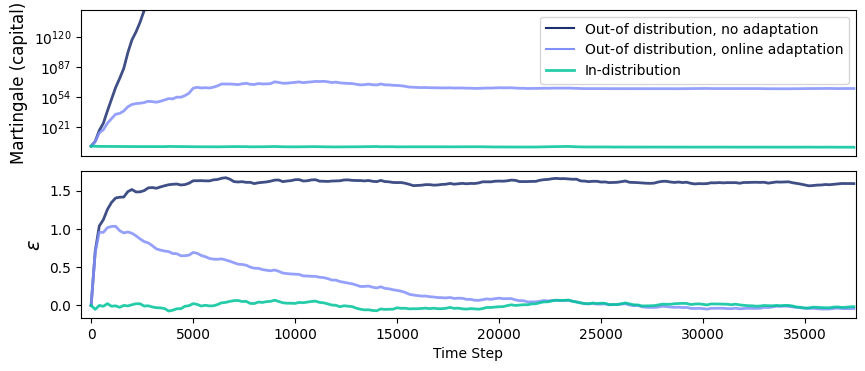

In [13]:


fig = plt.figure(figsize=(10, 4))
# Create a gridspec layout
gs = fig.add_gridspec(2, 1, hspace=0.10, wspace=0.05)  # Adjust horizontal spacing if needed
# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])  # Share y-axis with ax1



# Assuming `prog_df` is already defined and `model` is set
prog_df_filtered_1 = prog_df[(prog_df['exp_type'] == 'martingale') & (prog_df['model'] == model)& (prog_df['level'] == 5) & (prog_df['corruption'] == 'brightness')]
prog_df_filtered_2 = prog_df[(prog_df['exp_type'] == 'in_dist') & (prog_df['model'] == model) & (prog_df['method'] == 'pem') & (prog_df['seed'] == 2024)]

# Concatenate the filtered DataFrames
prog_df_filtered = pd.concat([prog_df_filtered_1, prog_df_filtered_2], ignore_index=True)


# Concatenate the filtered DataFrames
prog_df_filtered = pd.concat([prog_df_filtered_1, prog_df_filtered_2], ignore_index=True)

# Ensure 'martingales' and 'epsilons' columns are expanded correctly
prog_df_m_expanded = prog_df_filtered.explode('martingales')
prog_df_e_expanded = prog_df_filtered.explode('epsilons')
prog_df_m_expanded['martingale_value'] = prog_df_m_expanded['martingales'].astype(float)
prog_df_e_expanded['epsilon_value'] = prog_df_e_expanded['epsilons'].astype(float)

# Create a time_step column to use as x-axis
prog_df_m_expanded['time_step'] = prog_df_m_expanded.groupby(['model', 'corruption', 'level', 'exp_type', 'adapt']).cumcount()
prog_df_e_expanded['time_step'] = prog_df_e_expanded.groupby(['model', 'corruption', 'level', 'exp_type', 'adapt']).cumcount()
prog_df_m_expanded = prog_df_m_expanded.reset_index()
prog_df_e_expanded = prog_df_e_expanded.reset_index()

# Filtering time steps to every 100th step
prog_df_m_expanded = prog_df_m_expanded[prog_df_m_expanded['time_step'] % 200 == 0]
prog_df_e_expanded = prog_df_e_expanded[prog_df_e_expanded['time_step'] % 200 == 0]

# Plot martingales on ax1
sns.lineplot(data=prog_df_m_expanded[prog_df_m_expanded['exp_type'] == 'martingale'], x='time_step', y='martingale_value', hue='adapt', ax=ax1, palette=['#1d2f6f', '#8390fa'], linewidth=2, alpha=0.85)
sns.lineplot(data=prog_df_m_expanded[prog_df_m_expanded['exp_type'] == 'in_dist'], x='time_step', y='martingale_value', ax=ax1, label='In-distribution', color='#00c49a', linewidth=2, alpha=0.85)
ax1.set_yscale('log')
ax1.set_ylim(0, 1e150)
ax1.set_xlim(-500, 37500)
ax1.set_ylabel('Martingale (capital)', fontsize=12)
ax1.set_xlabel('')
ax1.set_xticks([])
ax1.legend(title='Setting')
handles, labels = ax1.get_legend_handles_labels()
labels[0] = 'Out-of distribution, no adaptation'
labels[1] = 'Out-of distribution, online adaptation'
print(labels)
ax1.legend(handles, labels, loc='best', fontsize=10)

# Plot epsilons on ax2
sns.lineplot(data=prog_df_e_expanded[prog_df_e_expanded['exp_type'] == 'martingale'], x='time_step', y='epsilon_value', hue='adapt', ax=ax2, palette=['#1d2f6f', '#8390fa'], linewidth=2, alpha=0.85)
sns.lineplot(data=prog_df_e_expanded[prog_df_e_expanded['exp_type'] == 'in_dist'], x='time_step', y='epsilon_value', ax=ax2, color='#00c49a', linewidth=2, alpha=0.85)
# sns.lineplot(data=prog_df_e_expanded, x='time_step', y='epsilon_value', hue='exp_type', ax=ax2)
# ax2.set_yscale('log')
# ax2.set_title('Epsilon Values Over Time by Experiment Type')
ax2.set_xlabel('Time Step')
ax2.set_ylabel(r'$\epsilon$', fontsize=14)
ax2.legend_.remove()
ax2.set_xlim(-500, 37500)

plt.savefig('figures/martingale.svg', format='svg')
plt.show()


1


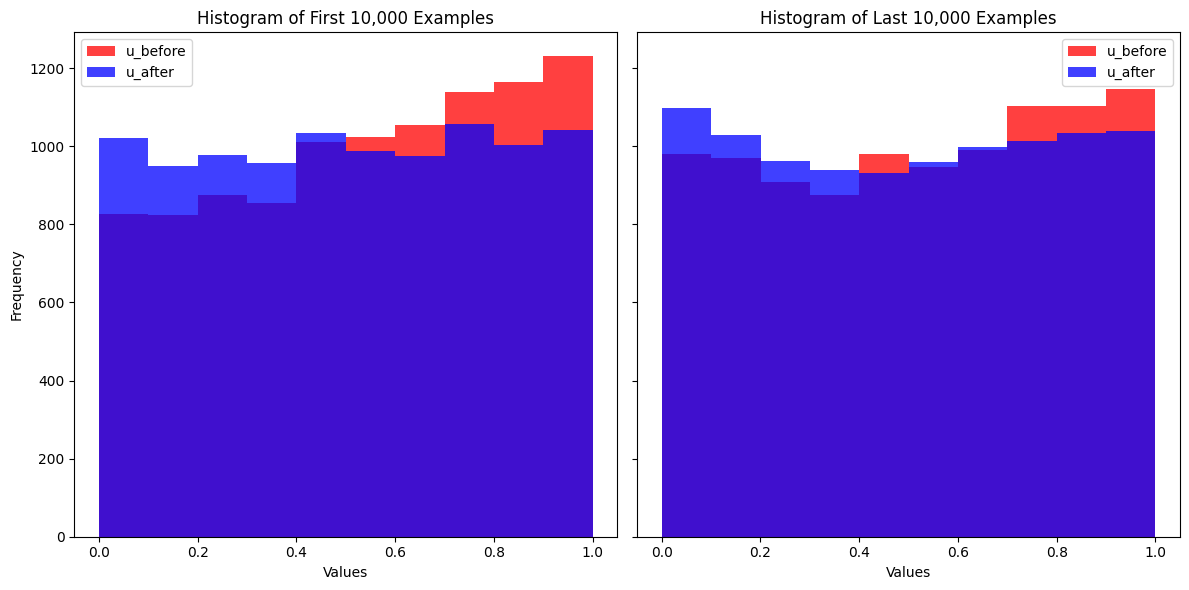

In [22]:

prog_df_filtered = prog_df[(prog_df['exp_type'] == 'bs1') & (prog_df['corruption'] == 'brightness') & (prog_df['model'] == model) & (prog_df['method'] == 'pem')  &  (prog_df['seed'] == 2024) & (prog_df['exp_comment'] == 'orig_match_loss')]
print(len(prog_df_filtered))

u_before = prog_df_filtered['u_before'].values[0]
u_after = prog_df_filtered['u_after'].values[0]

n_examples = 10000

# First 4000 examples
first_4000_before = u_before[:n_examples]
first_4000_after = u_after[:n_examples]

# Last 4000 examples
last_4000_before = u_before[-n_examples:]
last_4000_after = u_after[-n_examples:]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)  # sharey to have the same y-axis for comparison

# Plot the first 4000 examples on the first subplot
axes[0].hist(first_4000_before, color='red', alpha=0.75, label='u_before', bins=10)
axes[0].hist(first_4000_after, color='blue', alpha=0.75, label='u_after', bins=10)
axes[0].set_title(f'Histogram of First {n_examples:,} Examples')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Plot the last 4000 examples on the second subplot
axes[1].hist(last_4000_before, color='red', alpha=0.75, label='u_before', bins=10)
axes[1].hist(last_4000_after, color='blue', alpha=0.75, label='u_after', bins=10)
axes[1].set_title(f'Histogram of Last {n_examples:,} Examples')
axes[1].set_xlabel('Values')
axes[1].legend()

# Display the plots
plt.tight_layout()
plt.show()



In [24]:
prog_df_natural_shift = prog_df[(prog_df['exp_type'] == 'natural_shift') & (prog_df['model'] == model) & (prog_df['seed'] == 2027)]
prog_df_natural_shift.columns

Index(['top1', 'top5', 'accs1', 'accs5', 'ents', 'ece', 'model_delta', 'data',
       'data_corruption', 'v2_path', 'output', 'seed', 'gpu', 'debug',
       'workers', 'test_batch_size', 'if_shuffle', 'level', 'corruption',
       'fisher_size', 'fisher_alpha', 'e_margin', 'd_margin', 'method',
       'model', 'exp_type', 'cont_size', 'severity_list', 'temp',
       'exp_comment', 'sar_margin_e0', 'imbalance_ratio', 'gamma', 'eps_clip',
       'loss_fn', 'ub4', 'u_thresh', 'lr_factor', 'device', 'timestamp',
       'exp_name', 'lr', 'print_freq', 'epsilons', 'cdf'],
      dtype='object')

In [ ]:

import matplotlib.pyplot as plt

# Assuming you have a list of axes (`axes`) with plots, colors, labels, etc.
axes = [ax1, ax2, ax3]  # Replace with your actual axes

# Create a new figure
fig = plt.figure()

# Filter out '_stale' key from axes dictionaries (temporary fix)
axes_dict_list = [dict((k, v) for k, v in ax.__dict__.items() if k != 'figure' and k != '_stale') for ax in axes]

# Add subplots using filtered dictionaries
fig.add_subplot(211, **axes_dict_list[0])  # Add ax1 to first row, first column
fig.add_subplot(212, **axes_dict_list[1])  # Add ax2 to first row, second column
fig.add_subplot(221, **axes_dict_list[2])  # Add ax3 to second row, first column (spanning full width)

# (Optional) Customize the layout and appearance
fig.suptitle('Combined Plots')
plt.tight_layout()

plt.show()



In [ ]:
prog_df = prog_df[prog_df['method'] == 'pem']
print(prog_df.columns)

# Add an index for each item in the lists
prog_df['index'] = prog_df['epsilons'].apply(lambda x: list(range(len(x))))

# Explode the DataFrame
long_df = prog_df.explode(['epsilons', 'index'])

# Convert 'epsilons' to numeric if not already
long_df['epsilons'] = pd.to_numeric(long_df['epsilons'])


# Function to group and average every 10 data points
def average_in_batches(df, batch_size=10):
    # Group by every batch_size elements
    df['batch'] = df['index'].astype(int) // batch_size
    # Aggregate the mean of epsilons and take the last index in each batch
    batched_df = df.groupby(['batch', 'severity_list']).agg({'epsilons': 'mean', 'index': 'last'})
    return batched_df

# Apply the batching function
long_df = average_in_batches(long_df)


# Plotting with error bars
ax = sns.lineplot(data=long_df, x='index', y='epsilons', estimator='mean', hue='severity_list', palette='Set1')
for j in range(10):
    if j == 0:
        ax.axvline(j * 1000, color='k', linestyle='--',alpha=0.25, label='Severity shift')
    else:
        ax.axvline(j * 1000, color='k', linestyle='--',alpha=0.25)

ax.set_ylim(-0.1, 0.9)
ax.legend(title='Severity Order', loc='best', bbox_to_anchor=(1.03, 1), borderaxespad=0.)
plt.show()

In [ ]:
# plot_in_dist(df)
# plot_severity_shift(prog_df)
print_bs1_results(df)
# plot_corruption_shift(df, prog_df)

In [ ]:
ns_df = df[(df['exp_type'] == 'bs1')]
# Aggregate data to find the mean of 'top1' for each combination of 'model' and 'method'
aggregated_df = ns_df.groupby(['model', 'method'])['top1', 'ece', 'model_delta'].mean().reset_index()
aggregated_df

In [ ]:

print_bs1_results(df)


In [ ]:
# layout = (1 , len(gb))
# fig_size = (10,4)
# if exp_type == 'bs1':
#     fig_size = (10, 10)
#     layout = (len(gb), 1)
    


# # Create a 2x2 grid of subplots
# fig, axs = plt.subplots(layout[0], layout[1], figsize=fig_size)
# axs = axs.flatten()  # Flatten the array to make it easier to handle



# for i, (group, gdf) in enumerate(gb):
    
#     print(gdf[gdf['method'] == 'no_adapt']['seed'].unique())
#     # print(gdf[['method', 'top1', 'model_delta', 'ece', 'eps_clip', 'gamma']].sort_values(by=['eps_clip', 'gamma']))
#     print(f"number of experiments {len(gdf['seed'].unique())}")

#     if exp_type == 'in_dist':
#         plot_in_dist(gdf, axs, i)

#     elif exp_type == 'continual':
#         axs[i] = sns.lineplot(gdf, x='cont_size', y='top1', hue='method', ax=axs[i], errorbar=('ci', 0.68))
#         axs[i].legend_.remove()
#         handles, labels = axs[i].get_legend_handles_labels()
#         # new_labels = [f'{label}: {gdf.loc[gdf["method"] == label, "top1"].values[0]:.2f}%' for label in labels]
#         new_labels = [label for label in labels]
#         if i == len(gb) - 1:
#             # Add the new legend with the top1 accuracy
#             axs[i].legend(handles, new_labels, title='Method', loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

#     elif exp_type == 'bs1':
#         plot_bs1(gdf, axs, i)

#     elif exp_type == 'severity_shift':
#         # print(gdf[['method', 'top1', 'model_delta', 'ece', 'eps_clip', 'gamma']].sort_values(by=['eps_clip', 'gamma']))
#         axs[i] = sns.barplot(gdf, x='severity_list', y='top1', hue='method', ax=axs[i])
#         for p in axs[i].patches:
#             axs[i].annotate(format(p.get_height(), '.2f'),  # Format the value
#                         (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
#                         ha = 'center', va = 'center', 
#                         xytext = (0.8, -12),  # Offset text by 10 Photo vertically
#                         textcoords = 'offset points',
#                         rotation=90,  # Rotate the text 90 degrees
#                         fontsize=6)  # Make the font smaller


    
#     # plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# # plt.title(group)
# # plt.xticks(rotation=45)
# # plt.savefig('in_dist.png')
# # plt.show()
# # import pandas as pd
# # from IPython.display import display
# plt.tight_layout()
# plt.savefig('in_dist_main.svg', format='svg')
# # pd.options.display.max_columns = None
# # display(gdf)


In [ ]:


common_corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur',
	                    'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
	                    'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression']
ticks_positions = [(i) for i in range(len(common_corruptions))]

for cont_size, gdf_ in prog_df.groupby(['cont_size']):
    plt.figure(figsize=(10,4), dpi=150)
    window_size = cont_size // 1
    gb = gdf_.groupby(['model'])
    for group, gdf in gb:
        
        gdf['accs1_per_corr'] = gdf['accs1'].apply(lambda x: np.array(x).reshape(-1, window_size).mean(axis=1))
        rows = []
        for _, row in gdf.iterrows():
            for idx, val in enumerate(row['accs1_per_corr']):
                rows.append({**row.to_dict(), 'accs1_per_corr_value': val, 'time_point': idx})
        expanded_df = pd.DataFrame(rows)
        
        expanded_df['sort_key'] = expanded_df['method'] == 'pem'
        # Then sort by this key (False values first, then True values)
        expanded_df = expanded_df.sort_values('sort_key')
        expanded_df['extended_method'] = expanded_df['method'].astype(str) + '_' + expanded_df['loss_fn'].astype(str) + '_' + expanded_df['lr_factor'].astype(str) + '_' + expanded_df['exp_comment'].astype(str)
    
        # expanded_df = expanded_df[expanded_df['method'] == 'pem']
        
        # Now plot with seaborn
        plt.figure(figsize=(15, 6))
        for i in range(len(common_corruptions)):
            plt.axvline(i, color='k', linestyle='--',alpha=0.50)
            
        sns.lineplot(data=expanded_df, x='time_point', y='accs1_per_corr_value', hue='extended_method', style='exp_type', markers=True, dashes=False)
        
        
        
        plt.title(f'Performance Across Conditions - {cont_size} {group}')
        plt.xlabel('Condition / Time Point')
        plt.ylabel('Average Accuracy (accs1 per corruption)')
        plt.legend(title='Method and Experiment Type', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(ticks_positions, common_corruptions, rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 4), dpi=150)
        plt.title(f'Model: {group}')  # Optional: add a title to each plot with the group name
    
        for _, row in gdf.iterrows():
            if 'epsilons' in row and not np.isnan(row['epsilons']).any() and len(row['epsilons']) > window_size:  # Check if 'epsilons' is valid and long enough for the window
                # Calculate the rolling mean
                # smooth_epsilons = pd.Series(row['epsilons']).rolling(window=window_size, center=True).mean()
                smooth_epsilons = row['epsilons']
                plt.plot(smooth_epsilons, label=f"{row['lr_factor']}")  # Plot the smoothed data
            else:
                plt.plot(row['epsilons'], label=f"{row['lr_factor']}")  # Plot the original data if not enough points for smoothing
    
        plt.xlabel('Index')  # Label for the X axis
        plt.ylabel('Epsilons')  # Label for the Y axis
        plt.legend()  # Show legend to identify each line
        plt.show()  # Display the plot for the current group



In [ ]:

gb = prog_df.groupby(['model', 'loss_fn'])
for group, gdf in gb:
    print(group)
    plt.figure(figsize=(8,5), dpi=150)
    for i, row in gdf.iterrows():
        plt.plot(row['cdf'].quantiles, row['cdf'].probabilities, label=f"{row['method']}_{row['lr_factor']}")
    plt.legend()
    plt.show()

In [ ]:
gb = prog_df[prog_df['method'] == 'pem'].groupby(['model', 'loss_fn'])
window_size = 50000 // 128
for group, gdf in gb:
    


In [ ]:
prog_df.columns